In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torch.autograd import grad

In [14]:
torch.manual_seed(42)
np.random.seed(42)

In [15]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.linear_layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:  # No activation after last layer
                self.linear_layers.append(nn.Tanh())
    
    def forward(self, x, y, t):
        inputs = torch.cat([x, y, t], dim=1)
        output = inputs
        for layer in self.linear_layers:
            output = layer(output)
        return output

In [ ]:
def compute_loss(model, x, y, t, alpha, lambda_ic=1.0, lambda_bc=1.0):
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, y, t)
    du_dt = grad(u.sum(), t, create_graph=True)[0]
    du_dx = grad(u.sum(), x, create_graph=True)[0]
    du_dy = grad(u.sum(), y, create_graph=True)[0]
    
    du_dxx = grad(du_dx.sum(), x, create_graph=True)[0]
    du_dyy = grad(du_dy.sum(), y, create_graph=True)[0]
    
    pde_residual = du_dt - alpha * (du_dxx + du_dyy)
    physics_loss = torch.mean(pde_residual**2)
    u_left = model(torch.zeros_like(x), y, t)
    bc_left_loss = torch.mean(u_left**2)
    u_right = model(torch.ones_like(x), y, t)
    bc_right_loss = torch.mean(u_right**2)
    u_bottom = model(x, torch.zeros_like(y), t)
    bc_bottom_loss = torch.mean(u_bottom**2)
    u_top = model(x, torch.ones_like(y), t)
    bc_top_loss = torch.mean(u_top**2)
    u_initial = model(x, y, torch.zeros_like(t))
    initial_condition = torch.exp(-50*((x-0.5)**2 + (y-0.5)**2))
    ic_loss = torch.mean((u_initial - initial_condition)**2)
    
    # Total loss
    total_loss = (physics_loss + 
                 lambda_ic * ic_loss + 
                 lambda_bc * (bc_left_loss + bc_right_loss + bc_bottom_loss + bc_top_loss))
    
    return total_loss

In [17]:
def train_pinn(model, optimizer, epochs, alpha, n_samples=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Sample collocation points
        x = torch.rand(n_samples, 1, requires_grad=True)  # x ∈ [0,1]
        y = torch.rand(n_samples, 1, requires_grad=True)  # y ∈ [0,1]
        t = torch.rand(n_samples, 1, requires_grad=True)  # t ∈ [0,1]
        
        # Compute loss and backpropagate
        loss = compute_loss(model, x, y, t, alpha)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    return losses

In [18]:
alpha = 0.01  # Thermal diffusivity
layers = [3, 20, 20, 20, 1]  # Input: (x, y, t), Output: u

# Initialize model and optimizer
model = PINN(layers)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model
losses = train_pinn(model, optimizer, epochs=2000, alpha=alpha)

Epoch 0, Loss: 0.7842
Epoch 100, Loss: 0.0291
Epoch 200, Loss: 0.0343
Epoch 300, Loss: 0.0304
Epoch 400, Loss: 0.0322
Epoch 500, Loss: 0.0309
Epoch 600, Loss: 0.0355
Epoch 700, Loss: 0.0237
Epoch 800, Loss: 0.0310
Epoch 900, Loss: 0.0257
Epoch 1000, Loss: 0.0290
Epoch 1100, Loss: 0.0264
Epoch 1200, Loss: 0.0318
Epoch 1300, Loss: 0.0292
Epoch 1400, Loss: 0.0201
Epoch 1500, Loss: 0.0239
Epoch 1600, Loss: 0.0272
Epoch 1700, Loss: 0.0236
Epoch 1800, Loss: 0.0149
Epoch 1900, Loss: 0.0208


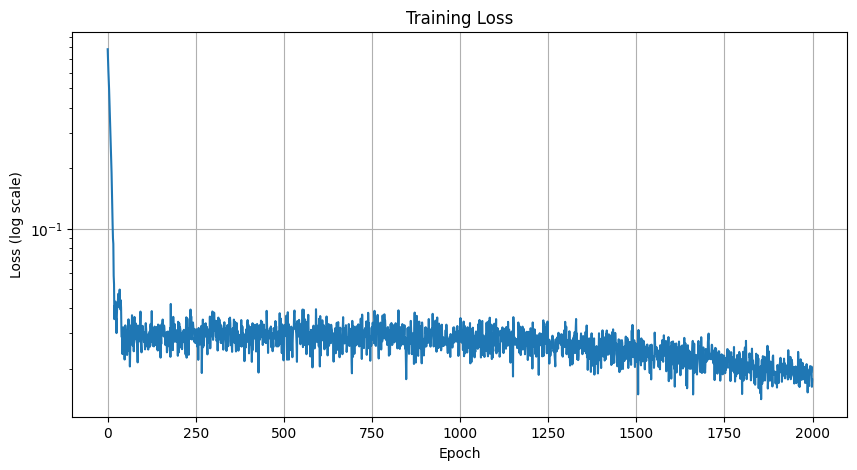

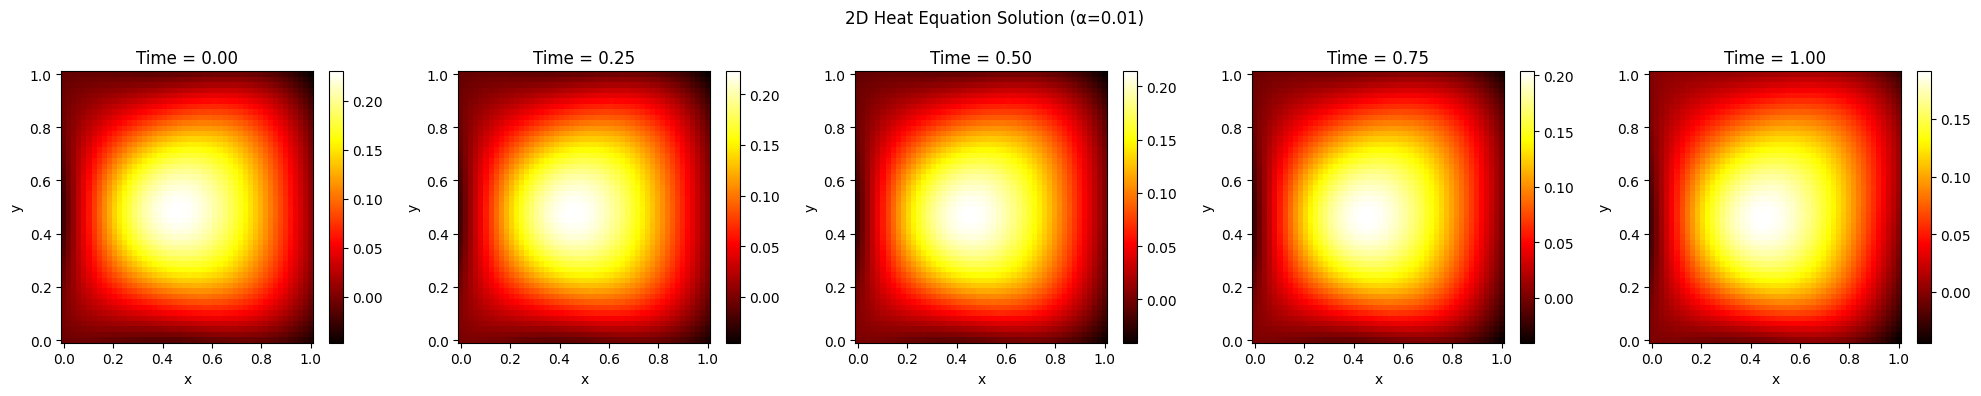

In [19]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# Visualization
def visualize_solution(model, alpha, timesteps=10):
    # Create spatial grid
    x = torch.linspace(0, 1, 50).view(-1, 1)
    y = torch.linspace(0, 1, 50).view(-1, 1)
    X, Y = torch.meshgrid(x.squeeze(), y.squeeze())
    
    # Prepare for plotting
    fig, axes = plt.subplots(1, timesteps, figsize=(20, 4))
    if timesteps == 1:
        axes = [axes]
    
    # Evaluate at different times
    for i, ax in enumerate(axes):
        t_val = i / (timesteps - 1) if timesteps > 1 else 1.0
        t = torch.full_like(X.reshape(-1, 1), t_val)
        
        with torch.no_grad():
            U = model(X.reshape(-1, 1), Y.reshape(-1, 1), t)
            U = U.reshape(X.shape).numpy()
        
        im = ax.pcolormesh(X.numpy(), Y.numpy(), U, cmap='hot', shading='auto')
        ax.set_title(f'Time = {t_val:.2f}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        fig.colorbar(im, ax=ax)
    
    plt.suptitle(f'2D Heat Equation Solution (α={alpha})')
    plt.tight_layout()
    plt.show()

# Visualize the solution
visualize_solution(model, alpha, timesteps=5)